In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data
from model import AEDist
import numpy as np
import os
import glob
import torch
import pickle

In [2]:
import numpy as np
import scprep
import torch
import sys
sys.path.append('../src/')
# from cvx_hull_gen import CvxHullGenDirichlet, CvxHullGen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pickle

In [3]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from diffusion import DiffusionModel
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model import AEDist
import magic
import torch
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

def compute_w2(gen, tru, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    M = ot.dist(gen, tru)
    M = torch.tensor(M, dtype=torch.float32, device=device)
    # M/=M.max()
    assert gen.shape[0] == tru.shape[0]
    n = gen.shape[0]
    a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    W = torch.sum(G0 * M)
    return torch.sqrt(W)

def eval_cvx(data_path, model_path, ae_run_id, pca_path, folder_path="../src/wandb/", entity='xingzhis', project='dmae', n_top_genes=10000, seed=423):
    with open(model_path, 'rb') as file:
        cvxmodel = pickle.load(file)
    data_latent = np.load(data_path)
    train_mask = data_latent['train_mask']
    generated_latent = model.generate((~train_mask).sum())
    data_latent_train = data_latent['data'][data_latent['train_mask']]
    # mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)
    # generated_latent = generated_latent * std_ + mean_
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    latent_gen = generated_latent.detach().cpu().numpy()
    latent_test = data_latent['data'][~data_latent['train_mask']]
    latent_train = data_latent['data'][data_latent['train_mask']]

    std = latent_train.std()
    noises = np.arange(1, 10) * 0.1
    w2s = []
    for noise in noises:
        noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
        w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
        w2s.append(w2)

    mean = latent_train.mean(axis=0)
    cov = np.cov(latent_train, rowvar=False)
    rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])
    
    res = np.array([noises, w2s]).T
    w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
    w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

    np.random.seed(seed)
    latent_train_subset_id = np.random.choice(np.arange(len(latent_train)), size=len(latent_test), replace=False)
    latent_train_subset = latent_train[latent_train_subset_id]
    w_train = compute_w2(latent_train_subset, latent_test).cpu().numpy()

    res_dict = dict(
        w_increasing_noise=res,
        w_noise=w_rand,
        w_gen=w_gen,
        w_train=w_train,
    )

    run = api.run(f"{entity}/{project}/{ae_run_id}")
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path, allow_pickle=True)
    model = AEDist.load_from_checkpoint(ckpt_path)
    model.eval()
    with torch.no_grad():
        gen_decoded = model.decode(generated_latent)
    with torch.no_grad():
        test_decoded = model.decode(torch.tensor(latent_test, dtype=torch.float32))
    test_ambient = data['data'][~data['is_train']]
    test_ambient = torch.tensor(test_ambient, dtype=torch.float)
    train_ambient = data['data'][data['is_train']]
    train_ambient = torch.tensor(train_ambient, dtype=torch.float)
    magic_op = magic.MAGIC()
    x_magic = magic_op.fit_transform(test_ambient.cpu().numpy())
    pc_data = np.load(pca_path)
    pca_loadings = pc_data['pca_loadings']
    data_mean = pc_data['data_mean']
    pca_data = x_magic
    orig_magic = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_magic = np.asarray(orig_magic)
    orig_magic = torch.tensor(orig_magic, dtype=torch.float32)
    pca_data = gen_decoded.cpu().numpy()
    orig_gen = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_gen = np.asarray(orig_gen)
    orig_gen = torch.tensor(orig_gen, dtype=torch.float32)
    pca_data = train_ambient.cpu().numpy()
    orig_train = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_train = np.asarray(orig_train)
    orig_train = torch.tensor(orig_train, dtype=torch.float32)
    pca_data = test_decoded.cpu().numpy()
    orig_dec = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_dec = np.asarray(orig_dec)
    orig_dec = torch.tensor(orig_dec, dtype=torch.float32)
    orig_vars = orig_magic.var(axis=0)
    top_100_idx = torch.argsort(orig_vars).flip(0)[:n_top_genes]
    magic_top100 = orig_magic[:,top_100_idx].cpu().numpy()
    gen_top100 = orig_gen[:,top_100_idx].cpu().numpy()
    dec_top100 = orig_dec[:,top_100_idx].cpu().numpy()
    corrs_magic = np.corrcoef(magic_top100, rowvar=False)
    corrs_gen = np.corrcoef(gen_top100, rowvar=False) 
    corrs_dec = np.corrcoef(dec_top100, rowvar=False)
    mse_gen = ((corrs_magic - corrs_gen)**2).mean()
    mse_dec = ((corrs_magic - corrs_dec)**2).mean()
    res_dict['corrs_magic'] = corrs_magic
    res_dict['corrs_gen'] = corrs_gen
    res_dict['corrs_dec'] = corrs_dec
    res_dict['mse_gen'] = mse_gen
    res_dict['mse_dec'] = mse_dec
    return res_dict

In [4]:
# because of environment conflicts 
def eval_cvx_given_data(data_path, result_path, ae_run_id, pca_path, folder_path="../src/wandb/", entity='xingzhis', project='dmae', n_top_genes=10000, seed=423):
    # with open(model_path, 'rb') as file:
    #     cvxmodel = pickle.load(file)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_latent = np.load(data_path)
    train_mask = data_latent['train_mask']
    generated_latent = torch.load(result_path)[:len(train_mask),:][~train_mask, :].to(device)
    data_latent_train = data_latent['data'][data_latent['train_mask']]
    # mean_, std_ = np.mean(data_latent_train, axis=0), np.std(data_latent_train, axis=0)
    # generated_latent = generated_latent * std_ + mean_
    latent_gen = generated_latent.detach().cpu().numpy()
    latent_test = data_latent['data'][~data_latent['train_mask']]
    latent_train = data_latent['data'][data_latent['train_mask']]

    std = latent_train.std()
    noises = np.arange(1, 10) * 0.1
    w2s = []
    for noise in noises:
        noisy_test = latent_test + np.random.randn(*latent_test.shape) * noise * std
        w2 = compute_w2(noisy_test, latent_test).detach().cpu().numpy()
        w2s.append(w2)

    mean = latent_train.mean(axis=0)
    cov = np.cov(latent_train, rowvar=False)
    rand_samples = np.random.multivariate_normal(mean, cov, latent_test.shape[0])
    
    res = np.array([noises, w2s]).T
    w_rand = compute_w2(rand_samples, latent_test).cpu().numpy()
    w_gen = compute_w2(latent_gen, latent_test).cpu().numpy()

    np.random.seed(seed)
    latent_train_subset_id = np.random.choice(np.arange(len(latent_train)), size=len(latent_test), replace=False)
    latent_train_subset = latent_train[latent_train_subset_id]
    w_train = compute_w2(latent_train_subset, latent_test).cpu().numpy()

    res_dict = dict(
        w_increasing_noise=res,
        w_noise=w_rand,
        w_gen=w_gen,
        w_train=w_train,
    )

    run = api.run(f"{entity}/{project}/{ae_run_id}")
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path, allow_pickle=True)
    model = AEDist.load_from_checkpoint(ckpt_path).to(device)
    model.eval()
    with torch.no_grad():
        gen_decoded = model.decode(generated_latent.to(model.device))
    with torch.no_grad():
        test_decoded = model.decode(torch.tensor(latent_test, dtype=torch.float32, device=model.device))
    test_ambient = data['data'][~data['is_train']]
    test_ambient = torch.tensor(test_ambient, dtype=torch.float)
    train_ambient = data['data'][data['is_train']]
    train_ambient = torch.tensor(train_ambient, dtype=torch.float)
    magic_op = magic.MAGIC()
    x_magic = magic_op.fit_transform(test_ambient.cpu().numpy())
    pc_data = np.load(pca_path)
    pca_loadings = pc_data['pca_loadings']
    data_mean = pc_data['data_mean']
    pca_data = x_magic
    orig_magic = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_magic = np.asarray(orig_magic)
    orig_magic = torch.tensor(orig_magic, dtype=torch.float32)
    pca_data = gen_decoded.cpu().numpy()
    orig_gen = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_gen = np.asarray(orig_gen)
    orig_gen = torch.tensor(orig_gen, dtype=torch.float32)
    pca_data = train_ambient.cpu().numpy()
    orig_train = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_train = np.asarray(orig_train)
    orig_train = torch.tensor(orig_train, dtype=torch.float32)
    pca_data = test_decoded.cpu().numpy()
    orig_dec = np.dot(pca_data, pca_loadings.T) + data_mean
    orig_dec = np.asarray(orig_dec)
    orig_dec = torch.tensor(orig_dec, dtype=torch.float32)
    orig_vars = orig_magic.var(axis=0)
    top_100_idx = torch.argsort(orig_vars).flip(0)[:n_top_genes]
    magic_top100 = orig_magic[:,top_100_idx].cpu().numpy()
    gen_top100 = orig_gen[:,top_100_idx].cpu().numpy()
    dec_top100 = orig_dec[:,top_100_idx].cpu().numpy()
    corrs_magic = np.corrcoef(magic_top100, rowvar=False)
    corrs_gen = np.corrcoef(gen_top100, rowvar=False) 
    corrs_dec = np.corrcoef(dec_top100, rowvar=False)
    mse_gen = ((corrs_magic - corrs_gen)**2).mean()
    mse_dec = ((corrs_magic - corrs_dec)**2).mean()
    res_dict['corrs_magic'] = corrs_magic
    res_dict['corrs_gen'] = corrs_gen
    res_dict['corrs_dec'] = corrs_dec
    res_dict['mse_gen'] = mse_gen
    res_dict['mse_dec'] = mse_dec
    return res_dict

In [5]:
ids_df = pd.read_csv('../dm_data/differnt_dims.csv')

In [6]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [7]:
ids_df.set_index('run_id', inplace=True)

In [8]:
ids_df

,data.name,emb_dim,validation/reconstr_loss,validation/dist_accuracy
run_id,,,,
9xtkqnkl,eb_subset_all,5,1.428262,0.866203
u98snjwi,eb_subset_all,15,1.315820,0.867569
9sapq4h8,eb_subset_all,20,1.294534,0.879244
m07wclny,eb_subset_all,25,1.277464,0.875017
p14vurq1,eb_subset_all,30,1.278060,0.880826
najohsy0,sea_ad_gaba_all,5,0.657298,0.918041
m2874yfn,sea_ad_gaba_all,15,0.638394,0.927088
4se1cs5d,sea_ad_gaba_all,20,0.639052,0.937962
islnpqz2,sea_ad_gaba_all,25,0.626545,0.937596


<Axes: title={'center': 'EB'}, xlabel='dim', ylabel='validation dist accuracy'>

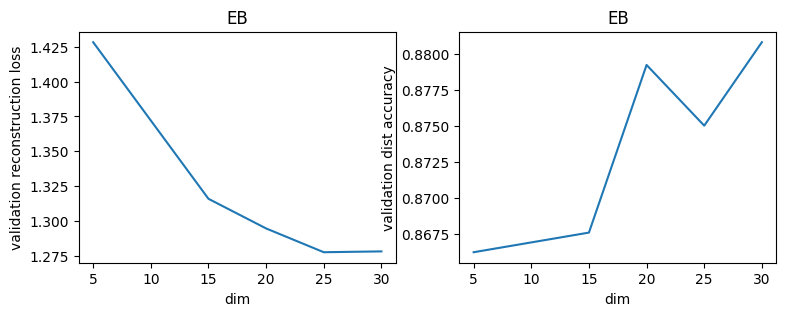

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
ids_df[ids_df['data.name'] == 'eb_subset_all'][['emb_dim','validation/reconstr_loss']].set_index('emb_dim').plot(title='EB', xlabel='dim', ylabel='validation reconstruction loss', legend=False, ax=axes[0])
ids_df[ids_df['data.name'] == 'eb_subset_all'][['emb_dim','validation/dist_accuracy']].set_index('emb_dim').plot(title='EB', xlabel='dim', ylabel='validation dist accuracy', legend=False, ax=axes[1])


<Axes: title={'center': 'SEA-AD GABA'}, xlabel='dim', ylabel='validation dist accuracy'>

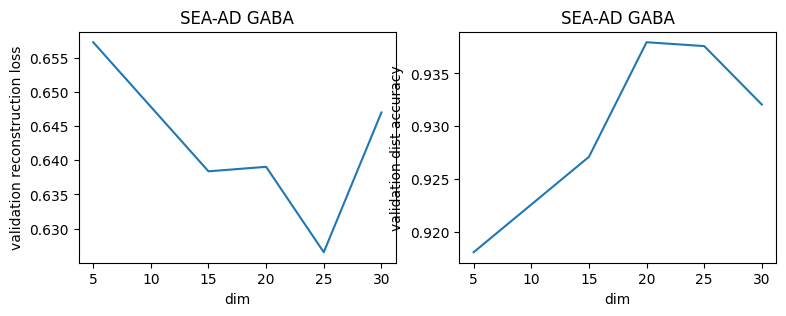

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
ids_df[ids_df['data.name'] == 'sea_ad_gaba_all'][['emb_dim','validation/reconstr_loss']].set_index('emb_dim').plot(title='SEA-AD GABA', xlabel='dim', ylabel='validation reconstruction loss', legend=False, ax=axes[0])
ids_df[ids_df['data.name'] == 'sea_ad_gaba_all'][['emb_dim','validation/dist_accuracy']].set_index('emb_dim').plot(title='SEA-AD GABA', xlabel='dim', ylabel='validation dist accuracy', legend=False, ax=axes[1])


In [11]:
# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'zypygyg0'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

In [12]:
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

In [13]:
# data_names = df['data'].unique()
ids_df['data_path'] = '../dm_data/' + ids_df['data.name'] + '_' + ids_df['emb_dim'].apply(str) + '_dm.npz'
ids_df['model_path'] = '../cvx_hull_models/' + ids_df['data.name'] + '_' + ids_df['emb_dim'].apply(str) + '_dm.npz.pkl'
ids_df['result_path'] = '../cvx_hull_models/' + ids_df['data.name'] + '_' + ids_df['emb_dim'].apply(str) + '_dm.npz.pt'


In [14]:
results = []
for i in range(len(ids_df)):
    data_path = ids_df.iloc[i,:]['data_path']
    # model_path = ids_df.iloc[i,:]['model_path']
    result_path = ids_df.iloc[i,:]['result_path']
    ae_run_id = ids_df.index[i]
    idx = ids_df.index[i]
    # run_id = df[df['data'] == data_name]['run_id'].values[0]
    pca_path = f"../data/{ids_df.loc[ae_run_id,:]['data.name']}_pcs.npz"
    # run = api.run(f"{entity}/{project}/{run_id}")
    # cfg = OmegaConf.create(run.config)
    res_dict = eval_cvx_given_data(data_path, result_path, ae_run_id, pca_path)
    res_dict['data'] = ids_df.loc[idx,:]['data.name']
    res_dict['emb_dim'] = ids_df.loc[idx,:]['emb_dim']
    results.append(res_dict)

Calculating MAGIC...
  Running MAGIC on 600 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating imputation...
Calculated MAGIC in 0.05 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 600 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating imputation...
Calculated MAGIC in 0.05 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 600 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating imputation...
Calculated MAGIC in 0.05 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 600 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating imputation...
Calculated MAGIC in 0.06 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 600 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating imputation...
Calculated MAGIC in 0.07 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating imputation...
Calculated MAGIC in 0.14 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating imputation...
Calculated MAGIC in 0.14 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating imputation...
Calculated MAGIC in 0.14 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating imputation...
Calculated MAGIC in 0.14 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

Calculating MAGIC...
  Running MAGIC on 757 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.06 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating imputation...
Calculated MAGIC in 0.14 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mean', torch.tensor(mean, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/../src/model.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('std', torch.tensor(std, dtype=torch.float32), persistent=True)
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore t

In [ ]:
with open('cvx_results_eval.pkl', 'wb') as file:
    pickle.dump(results, file)